In [1]:
from transformers import AutoImageProcessor
import torchvision.transforms as transforms
import numpy as np
import torch
from trak import TRAKer

from src.train import train_model
from src.early_stopping import EarlyStopping
from src.dataset import get_dataset_split, get_dl_targets, get_chosen_classes
from src.model import get_model, compute_test_dataset_predictions, recall_for_class
from src.trak_utils import ResNetOutput, featurize_traker, get_traker_scores
from src.plots import plot_single_image, plot_extreme_two_trak_examples_for_image
from src.class_metrics import compute_class_weights, compute_class_alignment_scores, compute_class_weights_original_formula

torch.manual_seed(42)
torch.cuda.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
args = {
    'lr': 1e-4, 
    'batch_size': 64,
    'batch_size_reduced': 32,
    'num_epochs': 20,
    'epochs_per_checkpoint': 1,
    'dataset_path': "data/food-101/food-101/images",
    'resnet_version': "microsoft/resnet-18",
    'train_split_rate': 0.8,
    'test_split_rate': 0.2
}

In [3]:
processor = AutoImageProcessor.from_pretrained(args['resnet_version'])

def preprocess_image(image):
    image = transforms.functional.pil_to_tensor(image)
    processed_image = processor.preprocess(image)["pixel_values"][0]
    return torch.from_numpy(processed_image)

# classes:
# bruschetta, garlic bread, grilled salmon, omelette, pancakes,
# pizza, porkchop, spaghetti bolognese, spaghetti carbonara, steak

num_classes = 10
chosen_indices = [10, 46, 50, 67, 72, 76, 77, 90, 91, 93]

assert num_classes == len(chosen_indices)

chosen_classes = get_chosen_classes(args['dataset_path'], chosen_indices)

print("Chosen classes: " + str(chosen_classes))

train_dataset, test_dataset = get_dataset_split(args['dataset_path'], chosen_indices, args['train_split_rate'], args['test_split_rate'], preprocess_image)

train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=args['batch_size'], shuffle=True)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=args['batch_size'], shuffle=False)

model = get_model(args['resnet_version'], num_classes)

Chosen classes: ['bruschetta', 'garlic_bread', 'grilled_salmon', 'omelette', 'pancakes', 'pizza', 'pork_chop', 'spaghetti_bolognese', 'spaghetti_carbonara', 'steak']


In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
early_stopping = EarlyStopping(patience=3, min_delta=0.001)
model_finetuned_path = "model_finetuned_baseline.pth"

# baseline results - valid loss: 0.513, valid acc: 0.841
train_model(model, train_dl, test_dl, args['num_epochs'], optimizer, early_stopping=early_stopping, epochs_per_checkpoint=args['epochs_per_checkpoint'], model_save_path=model_finetuned_path)

torch.save(model.state_dict(), model_finetuned_path)

100%|██████████| 32/32 [00:19<00:00,  1.63it/s]


[Epoch 1] Loss: 0.899, Train Acc: 0.706,Valid loss: 0.589 Valid Acc: 0.802


100%|██████████| 32/32 [00:20<00:00,  1.60it/s]


[Epoch 2] Loss: 0.281, Train Acc: 0.922,Valid loss: 0.542 Valid Acc: 0.823


 21%|██        | 26/125 [00:19<01:15,  1.32it/s]


KeyboardInterrupt: 

In [5]:
model_finetuned_path = "model_finetuned_baseline.pth"
checkpoint = torch.load(model_finetuned_path,  map_location=device)
model.load_state_dict(checkpoint)
model = model.to(device)

In [6]:
train_dl_no_shuffle = torch.utils.data.DataLoader(train_dataset, batch_size=args['batch_size_reduced'], shuffle=False)
test_dl_no_shuffle = torch.utils.data.DataLoader(test_dataset, batch_size=args['batch_size_reduced'], shuffle=False)

In [ ]:
traker = TRAKer(model=model,
                task=ResNetOutput(),
                train_set_size=len(train_dl_no_shuffle.dataset))

In [ ]:
model_id = 0
test_scores_path = "test_scores.npy"
traker.load_checkpoint(checkpoint, model_id=0)

exp_name = "test_val"

featurize_traker(traker, train_dl_no_shuffle)

test_scores = get_traker_scores(traker, exp_name, checkpoint, model_id, test_dl) 

np.save(test_scores_path, test_scores)

In [8]:
test_scores_path = "test_scores.npy"
test_scores = np.load(test_scores_path)

In [10]:
targets = get_dl_targets(test_dl_no_shuffle)

preds = compute_test_dataset_predictions(model, test_dl_no_shuffle)

class_weights = compute_class_weights(preds, targets, num_classes)
class_weights

100%|██████████| 63/63 [00:23<00:00,  2.74it/s]


array([1.65128706, 1.94470773, 1.83594766, 1.96861238, 1.33618492,
       1.31584568, 3.12277379, 1.20719328, 1.11670319, 1.97544452])

In [11]:
group_alignment_scores = compute_class_alignment_scores(test_scores, targets, class_weights, num_classes)
(group_alignment_scores < 0).sum()

100%|██████████| 8000/8000 [00:01<00:00, 6061.27it/s]


2888

In [13]:
# looking to remove only a small fraction of hopefully impactful examples
sorted_group_alignment_scores = np.sort(group_alignment_scores)
top_k_to_remove = 200
example_indices_to_keep = np.nonzero(~(group_alignment_scores < sorted_group_alignment_scores[top_k_to_remove]))[0]
len(example_indices_to_keep)

7800

In [17]:
train_data_after_trak = torch.utils.data.Subset(train_dataset, example_indices_to_keep)
train_dl_after_trak = torch.utils.data.DataLoader(train_data_after_trak, batch_size=args['batch_size'], shuffle=True)

model_after_trak = get_model(args['resnet_version'], num_classes)

In [15]:
optimizer = torch.optim.Adam(model_after_trak.parameters(), lr=args['lr'])
early_stopping = EarlyStopping(patience=3, min_delta=0.001)
model_after_trak_path = "model_after_trak.pth"

# results after removing examples selected by TRAK - valid loss: 0.499, valid acc: 0.841
train_model(model_after_trak, train_dl_after_trak, test_dl, args['num_epochs'], optimizer, early_stopping=early_stopping)

torch.save(model_after_trak.state_dict(), model_after_trak_path)

100%|██████████| 32/32 [00:23<00:00,  1.34it/s]


[Epoch 1] Loss: 0.885, Train Acc: 0.706,Valid loss: 0.586 Valid Acc: 0.802


100%|██████████| 32/32 [00:23<00:00,  1.37it/s]


[Epoch 2] Loss: 0.277, Train Acc: 0.923,Valid loss: 0.540 Valid Acc: 0.821


100%|██████████| 32/32 [00:23<00:00,  1.38it/s]


[Epoch 3] Loss: 0.077, Train Acc: 0.988,Valid loss: 0.530 Valid Acc: 0.831


100%|██████████| 32/32 [00:23<00:00,  1.39it/s]


[Epoch 4] Loss: 0.025, Train Acc: 0.999,Valid loss: 0.499 Valid Acc: 0.841


100%|██████████| 32/32 [00:24<00:00,  1.32it/s]


[Epoch 5] Loss: 0.012, Train Acc: 1.000,Valid loss: 0.528 Valid Acc: 0.836


100%|██████████| 32/32 [00:30<00:00,  1.05it/s]


[Epoch 6] Loss: 0.007, Train Acc: 1.000,Valid loss: 0.530 Valid Acc: 0.838


100%|██████████| 32/32 [00:24<00:00,  1.33it/s]

[Epoch 7] Loss: 0.005, Train Acc: 1.000,Valid loss: 0.546 Valid Acc: 0.844
Early stopping at epoch 7


In [20]:
checkpoint = torch.load(model_after_trak_path, map_location=device)
model_after_trak.load_state_dict(checkpoint)
model_after_trak = model_after_trak.to(device)

## Improved predictions on some examples

In [21]:
preds_after_trak = compute_test_dataset_predictions(model_after_trak, test_dl_no_shuffle)
class_weights_after_trak = compute_class_weights(preds_after_trak, targets, num_classes)

100%|███████████████████████████████████████████| 63/63 [01:12<00:00,  1.15s/it]


In [22]:
# worst class performance has improved and all the other classes' performance is similar
# suggesting that the change in the formula was correct - the results are what they should be

class_weights_after_trak, class_weights, class_weights_after_trak - class_weights

(array([1.73049508, 1.83982988, 1.93802885, 1.85589777, 1.35190535,
        1.30825936, 2.37668831, 1.17909161, 1.16607468, 2.20870831]),
 array([1.65543037, 1.94837707, 1.84804875, 1.98177936, 1.33065145,
        1.31326314, 3.0872217 , 1.20708484, 1.11296474, 1.98765418]),
 array([ 0.07506471, -0.10854719,  0.0899801 , -0.12588159,  0.0212539 ,
        -0.00500378, -0.71053338, -0.02799323,  0.05310993,  0.22105413]))

In [23]:
# the worst class was class number 1 - "garlic bread"
# now we will examine both models' performance on this class

f"{recall_for_class(model, test_dl_no_shuffle, 1):.3f}", f"{recall_for_class(model_after_trak, test_dl_no_shuffle, 1):.3f}"

100%|███████████████████████████████████████████| 63/63 [00:20<00:00,  3.08it/s]


('0.811', '0.842')

## Surprising / insightful examples

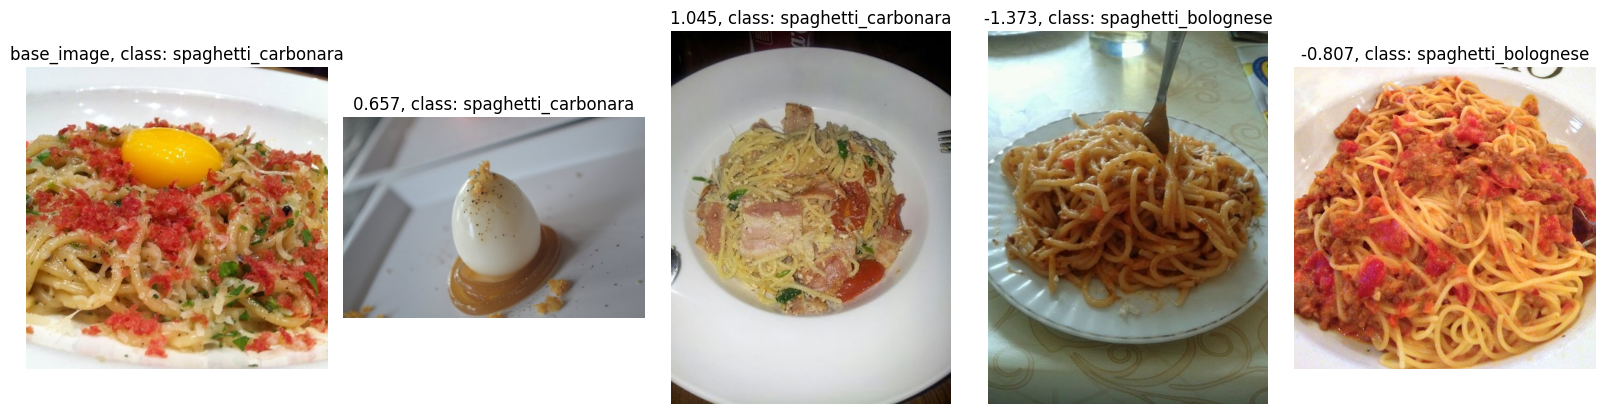

In [24]:
train_dataset_no_transform, test_dataset_no_transform = get_dataset_split(
    args['dataset_path'],
    chosen_indices,
    args['train_split_rate'],
    args['test_split_rate'],
    transforms.ToTensor())

image_id = 6

plot_extreme_two_trak_examples_for_image(test_scores, train_dataset_no_transform, test_dataset_no_transform, image_id, chosen_classes)

# reminder - some images have incorrect classes on purpose in this dataset
# like the second image on the plot for id 6

In [25]:
# the hope is that TRAK could help us in finding such images so that we could remove them
# let's examine the mislabeled image mentioned earlier

mislabeled_image_id = 4258

group_alignment_scores[group_alignment_scores >= group_alignment_scores[mislabeled_image_id]]

# the mislabeled image is the 7th most positively important example in the dataset, according to TRAK results - this should not be the case

array([0.19869503, 0.60739114, 0.43172198, 0.2705717 , 0.19379922,
       0.2105725 , 0.67511097])

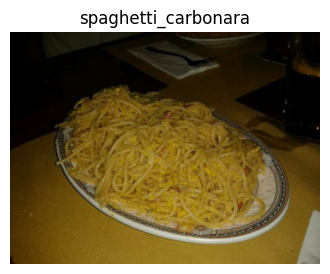

In [26]:
# let's examine the image (and its class), where the alignment score is the highest

top_alignment_image_id = np.argmax(group_alignment_scores)
top_alignment_image = train_dataset_no_transform[top_alignment_image_id][0]
top_alignment_image_class = train_dataset_no_transform[top_alignment_image_id][1]

plot_single_image(top_alignment_image, chosen_classes[top_alignment_image_class])

# hard to say what's unusual in this image

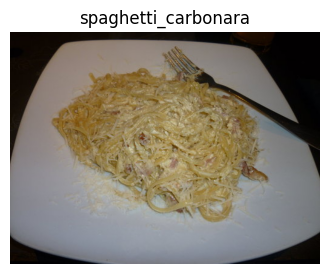

In [27]:
# let's examine the image with lowest score

bottom_alignment_image_id = np.argmin(group_alignment_scores)
bottom_alignment_image = train_dataset_no_transform[bottom_alignment_image_id][0]
bottom_alignment_image_class = train_dataset_no_transform[bottom_alignment_image_id][1]

plot_single_image(bottom_alignment_image, chosen_classes[bottom_alignment_image_class])

# it's almost the same image as the one with the highest alignment score. it seems that spaghetti dishes have high variability in scores
# (also taking into account that egg image (mislabeled as spaghetti carbonara), which had many scores far from 0, not like other images)
# maybe the model is confused between spaghetti carbonara and bolognese

## Original class weights formula

In [28]:
# just to be sure, let's repeat the experiment with the original formula for computing class weights
class_weights_orig = compute_class_weights_original_formula(preds, targets, num_classes)
group_alignment_scores_orig = compute_class_alignment_scores(test_scores, targets, class_weights_orig, num_classes)
sorted_group_alignment_scores_orig = np.sort(group_alignment_scores_orig)
example_indices_to_keep_orig = np.nonzero(~(group_alignment_scores_orig < sorted_group_alignment_scores_orig[top_k_to_remove]))[0]

100%|█████████████████████████████████████| 8000/8000 [00:01<00:00, 6191.63it/s]


In [29]:
mislabeled_image_id = 4258

group_alignment_scores_orig[group_alignment_scores_orig >= group_alignment_scores_orig[mislabeled_image_id]], group_alignment_scores_orig[mislabeled_image_id]
# no significant difference

(array([0.1906579 , 0.25930987, 0.21162806, 0.15178538, 0.10229584,
        0.17153198]),
 0.10229584309164694)

## Opposite experiment - removing most positively impactful examples

In [14]:
# using changed formula for computing class weights
example_indices_to_keep_2 = np.nonzero(~(group_alignment_scores >= sorted_group_alignment_scores[len(group_alignment_scores) - top_k_to_remove]))[0]

train_data_after_trak_2 = torch.utils.data.Subset(train_dataset, example_indices_to_keep_2)
train_dl_after_trak_2 = torch.utils.data.DataLoader(train_data_after_trak_2, batch_size=args['batch_size'], shuffle=True)

model_after_trak_2 = get_model(args['resnet_version'], num_classes)

In [15]:
optimizer = torch.optim.Adam(model_after_trak_2.parameters(), lr=args['lr'])
early_stopping = EarlyStopping(patience=3, min_delta=0.001)

# results after removing most positively impactful examples selected by TRAK - valid loss: 0.502, valid acc: 0.834
train_model(model_after_trak_2, train_dl_after_trak_2, test_dl, args['num_epochs'], optimizer, early_stopping=early_stopping)

100%|██████████| 32/32 [00:39<00:00,  1.24s/it]


[Epoch 1] Loss: 0.918, Train Acc: 0.699,Valid loss: 0.585 Valid Acc: 0.797


100%|██████████| 32/32 [00:19<00:00,  1.68it/s]


[Epoch 2] Loss: 0.299, Train Acc: 0.914,Valid loss: 0.502 Valid Acc: 0.834


100%|██████████| 32/32 [00:20<00:00,  1.60it/s]


[Epoch 3] Loss: 0.084, Train Acc: 0.986,Valid loss: 0.522 Valid Acc: 0.834


100%|██████████| 32/32 [00:21<00:00,  1.46it/s]


[Epoch 4] Loss: 0.024, Train Acc: 0.999,Valid loss: 0.514 Valid Acc: 0.832


100%|██████████| 32/32 [00:22<00:00,  1.40it/s]

[Epoch 5] Loss: 0.011, Train Acc: 1.000,Valid loss: 0.539 Valid Acc: 0.837
Early stopping at epoch 5


In [100]:
torch.save(model_after_trak_2.state_dict(), "model_after_trak_top_scores_removed.pth")

## Original heuristic - removing all examples with negative alignment score

In [32]:
example_indices_to_keep = np.nonzero(~(group_alignment_scores < 0))[0]
len(example_indices_to_keep)

5114

In [33]:
train_data_after_trak = torch.utils.data.Subset(train_dataset, example_indices_to_keep)
train_dl_after_trak = torch.utils.data.DataLoader(train_data_after_trak, batch_size=args['batch_size'], shuffle=True)

model_after_trak = get_model(args['resnet_version'], num_classes)

In [104]:
optimizer = torch.optim.Adam(model_after_trak.parameters(), lr=args['lr'])
early_stopping = EarlyStopping(patience=3, min_delta=0.001)

# results after removing all examples with negative alignment score - val loss: 0.542, val acc: 0.829
train_model(model_after_trak, train_dl_after_trak, test_dl, args['num_epochs'], optimizer, early_stopping=early_stopping)

100%|██████████| 32/32 [00:44<00:00,  1.39s/it]


[Epoch 1] Loss: 0.987, Train Acc: 0.680,Valid loss: 0.659 Valid Acc: 0.780


100%|██████████| 32/32 [00:46<00:00,  1.44s/it]


[Epoch 2] Loss: 0.278, Train Acc: 0.924,Valid loss: 0.595 Valid Acc: 0.799


100%|██████████| 32/32 [00:42<00:00,  1.34s/it]


[Epoch 3] Loss: 0.079, Train Acc: 0.991,Valid loss: 0.542 Valid Acc: 0.829


100%|██████████| 32/32 [00:31<00:00,  1.02it/s]


[Epoch 4] Loss: 0.028, Train Acc: 0.999,Valid loss: 0.550 Valid Acc: 0.825


100%|██████████| 32/32 [00:40<00:00,  1.26s/it]


[Epoch 5] Loss: 0.014, Train Acc: 1.000,Valid loss: 0.549 Valid Acc: 0.831


100%|██████████| 32/32 [00:25<00:00,  1.27it/s]

[Epoch 6] Loss: 0.009, Train Acc: 1.000,Valid loss: 0.561 Valid Acc: 0.825
Early stopping at epoch 6


## Shortcut learning / simplicity bias

In [ ]:
# nothing we found in this regard - we found the results unintuitive (although worst-class performance improved after removing examples with TRAK)